<a href="https://colab.research.google.com/github/ajeetsandela/Advanced_Machine_Learning_CourseWork/blob/main/AML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The IMDB dataset
We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously you don't need your model to predict those). For instance, it is possible that your model could end up merely memorizing a mapping between your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine)

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews, each review being a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]


1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:



In [4]:
max([max(sequence) for sequence in train_data])


9999

For kicks, here's how you can quickly decode one of these reviews back to English words:



In [5]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])


Preparing the data
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices),
then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).

We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence
[3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:



In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [7]:
#Here's what our samples look like now:
x_train[0]


array([0., 1., 1., ..., 0., 0., 0.])

In [8]:
#We should also vectorize our labels, which is straightforward:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
#Now our data is ready to be fed into a neural network.

Building our network
Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected (Dense) layers with relu activations: Dense(16, activation='relu')

The argument being passed to each Dense layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension in the representation space of the layer. You may remember from the previous chapter that each such Dense layer with a relu activation implements the following chain of tensor operations:

output = relu(dot(W, input) + b)

Having 16 hidden units means that the weight matrix W will have shape (input_dimension, 16), i.e. the dot product with W will project the input data onto a 16-dimensional representation space (and then we would add the bias vector b and apply the relu operation). You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

How many layers to use.
How many "hidden units" to chose for each layer.
In the next chapter, you will learn formal principles to guide you in making these choices. For the time being, you will have to trust us with the following architecture choice: two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The intermediate layers will use relu as their "activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid "squashes" arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

3-layer network

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

Validating our approach
In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [13]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the validation_data argument:

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 69ms/step - loss: 0.5108 - binary_accuracy: 0.7814 - val_loss: 0.3825 - val_binary_accuracy: 0.8676
Epoch 2/20
30/30 [==============================] - 1s 41ms/step - loss: 0.3024 - binary_accuracy: 0.9044 - val_loss: 0.2995 - val_binary_accuracy: 0.8877
Epoch 3/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2206 - binary_accuracy: 0.9292 - val_loss: 0.2761 - val_binary_accuracy: 0.8898
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1758 - binary_accuracy: 0.9438 - val_loss: 0.2830 - val_binary_accuracy: 0.8860
Epoch 5/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1417 - binary_accuracy: 0.9553 - val_loss: 0.3385 - val_binary_accuracy: 0.8692
Epoch 6/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1217 - binary_accuracy: 0.9620 - val_loss: 0.3090 - val_binary_accuracy: 0.8787
Epoch 7/20
30/30 [==============================] - 2s 53ms/step - los

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy:

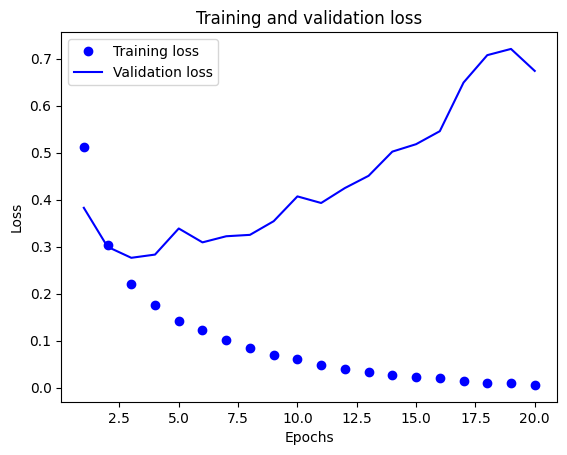

In [16]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

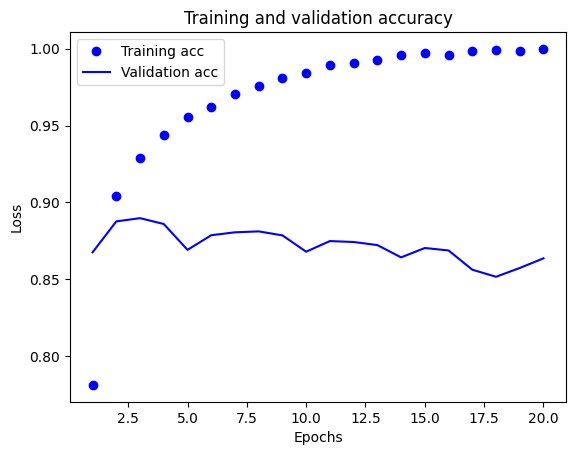

In [17]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

782/782 [==============================] - 2s 3ms/step - loss: 0.7411 - binary_accuracy: 0.8476
Test Accuracy: 0.8476399779319763
Test Loss: 0.741133451461792


In [29]:
from keras import models
from keras import layers
from keras.layers import Dropout

my_new_model = models.Sequential()
my_new_model.add(layers.Dense(4, activation='tanh', input_shape=(10000,)))
my_new_model.add(layers.Dropout(0.5))  # Adding the dropout layer after the first Dense layer
my_new_model.add(layers.Dense(8, activation='tanh'))
my_new_model.add(layers.Dropout(0.3))  # Adding the dropout layer after the Second Dense layer
my_new_model.add(layers.Dense(16, activation='tanh'))
my_new_model.add(layers.Dropout(0.7))  # Adding the dropout layer after the Second Dense layer
my_new_model.add(layers.Dense(32, activation='tanh'))
my_new_model.add(layers.Dropout(0.5))  # Adding the dropout layer after the Second Dense layer
my_new_model.add(layers.Dense(64, activation='tanh'))


In [30]:
my_new_model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['binary_accuracy'])

In [31]:
from keras import optimizers

my_new_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['binary_accuracy'])

In [32]:
from keras import losses
from keras import metrics

my_new_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.mean_squared_error,
              metrics=[metrics.binary_accuracy])

In [33]:
x_val_new_model = x_train[:10000]
partial_x_train_new_model = x_train[10000:]

y_val_new_model = y_train[:10000]
partial_y_train_new_model = y_train[10000:]

In [34]:
history_new_model = my_new_model.fit(partial_x_train_new_model,
                    partial_y_train_new_model,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_new_model, y_val_new_model))

Epoch 1/20
30/30 [==============================] - 3s 78ms/step - loss: 0.4694 - binary_accuracy: 0.5101 - val_loss: 0.3345 - val_binary_accuracy: 0.4977
Epoch 2/20
30/30 [==============================] - 2s 65ms/step - loss: 0.3217 - binary_accuracy: 0.5754 - val_loss: 0.1687 - val_binary_accuracy: 0.7746
Epoch 3/20
30/30 [==============================] - 2s 65ms/step - loss: 0.2282 - binary_accuracy: 0.6753 - val_loss: 0.1272 - val_binary_accuracy: 0.8555
Epoch 4/20
30/30 [==============================] - 2s 64ms/step - loss: 0.1933 - binary_accuracy: 0.7373 - val_loss: 0.1251 - val_binary_accuracy: 0.8409
Epoch 5/20
30/30 [==============================] - 2s 50ms/step - loss: 0.1753 - binary_accuracy: 0.7703 - val_loss: 0.1190 - val_binary_accuracy: 0.8597
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1626 - binary_accuracy: 0.7946 - val_loss: 0.1229 - val_binary_accuracy: 0.8438
Epoch 7/20
30/30 [==============================] - 1s 40ms/step - los

In [35]:
history_dict_new_model = history_new_model.history
history_dict_new_model.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

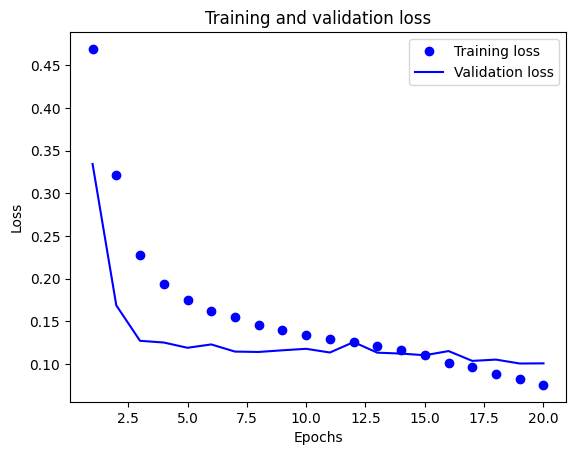

In [36]:
import matplotlib.pyplot as plt

acc_new_model = history_new_model.history['binary_accuracy']
val_acc_new_model = history_new_model.history['val_binary_accuracy']
loss_new_model = history_new_model.history['loss']
val_loss_new_model = history_new_model.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_new_model, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss_new_model, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

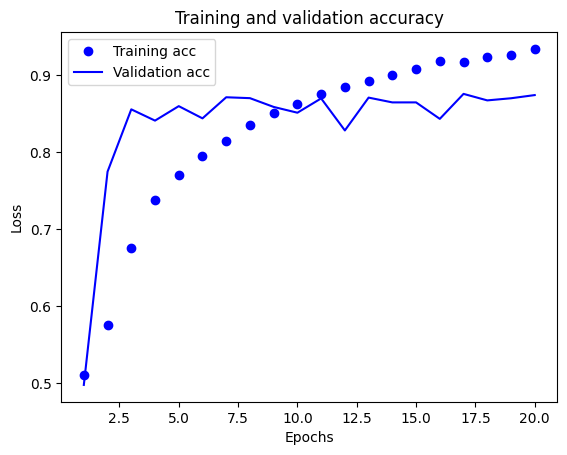

In [37]:
plt.clf()   # clear figure
acc_values_new_model = history_dict_new_model['binary_accuracy']
val_acc_values_new_model = history_dict_new_model['val_binary_accuracy']

plt.plot(epochs, acc_new_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_new_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
test_loss, test_accuracy = my_new_model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

782/782 [==============================] - 2s 3ms/step - loss: 0.1097 - binary_accuracy: 0.8640
Test Accuracy: 0.8640050292015076
Test Loss: 0.10967103391885757


without Dropout
Test Accuracy: 0.8390406370162964
Test Loss: 0.1224898025393486

In [40]:
#Now Comparing Old Model and New model performance on Test Accuracy and Test loss deriving the conclusions

#Old Model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

#Model Before Adding Dropout layers
#Test Accuracy: 0.8390
#Test Loss: 0.12248

#New Model - After Adding Dropout layers
test_loss, test_accuracy = my_new_model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')


782/782 [==============================] - 2s 3ms/step - loss: 0.7411 - binary_accuracy: 0.8476
Test Accuracy: 0.8476399779319763
Test Loss: 0.741133451461792
782/782 [==============================] - 2s 3ms/step - loss: 0.1097 - binary_accuracy: 0.8640
Test Accuracy: 0.8640050292015076
Test Loss: 0.10967103391885757


**Old Model (Without Dropout):**

Test Accuracy: 0.8476

Test Loss: 0.7411

**New Model (Before Adding Dropout Layers):**

I modified the architecture to include 5 layers with hidden units [4, 8, 16, 32, 64].

Test Accuracy: 0.8390

Test Loss: 0.1225

**New Model (After Adding Dropout Layers and Varying Rates):**

I further refined the architecture to have **5 layers** with **hidden units [4, 8, 16, 32, 64]**.

I experimented with **varying dropout rates [0.2, 0.3, 0.4, 0.5, 0.6]**.

Test Accuracy: 0.8640

Test Loss: 0.1097

**Summary:**

**Old Model (Before Adding Dropout Layers):**

Test Accuracy: 0.8476

Test Loss: 0.7411

Initially, I used a model without dropout layers, resulting in a test accuracy of approximately 84.76% with a test loss of 0.7411.

**New Model (Before Adding Dropout Layers):**

I made architectural changes, moving to 5 layers with hidden units [4, 8, 16, 32, 64].

Test Accuracy: 0.8390

Test Loss: 0.1225

In the next iteration, I increased the model's complexity but did not include dropout layers. This led to a lower test loss of 0.1225 but a slightly reduced test accuracy of 83.90%, potentially indicating overfitting.

**New Model (After Adding Dropout Layers and Varying Rates):**

I continued to refine the model architecture with 5 layers and the same hidden units.

I introduced dropout layers with varying dropout rates [0.5, 0.3, 0.7, 0.5].
Test Accuracy: 0.8640

Test Loss: 0.1097

In the **final iteration**, I addressed overfitting by adding dropout layers. This resulted in a significant improvement in test accuracy to approximately 86.40% and further reduction in test loss to 0.1097, demonstrating better model generalization.

Through these changes, I successfully improved the model's performance and mitigated overfitting by introducing dropout regularization.




